# Inspired by eigendecomposition
# Pokemon's 19th Type According to Simple Math 
# https://www.youtube.com/watch?v=f4OY4qhCI04&t=559s
# Pokemon's (Actual) 19th Type According to Simple Math 
# https://www.youtube.com/watch?v=Ov85T9xO3Wk
# how to turn matrix into matrix of probabilities and calculate eigenvectors for ranking types

Any non-negative matrix always has a real, positive dominant eigenvalue (Perron root). The corresponding right and left eigenvectors are strictly positive and are unique up to a positive scalar multiple. Which is our case since we have 0 being the lowest values. 

Finding the principal eigenvector corresponds to finding the stationary state that the system converges to over time. To ensure the system has a UNIQUE final state we need to check for two things.

1.Irreducibility: it is possible to get from any state to any other state. This is equivalent to saying the graph is strongly connected. This is true since the pokemon types chart CAN'T be split into blocks sub matrices. In the prah we can see that there is no isolated cycle of types. This ensures the EXISTENCE of a stationary state.

2. Aperiodic: GCD of lengths of all cycles is 1. Since every pokemon type damages itself, there is a hopping transition from every edge to itself, meaning a cycle of length 1. This ensures the UNIQUENESS of the stationary state.

Hence we can interpret the Principal Eigenvector of our matrices as the final state after "infinite pokemon battles".

In [93]:
import pandas as pd
import numpy as np

import pokemon_stats.viz as viz
import pokemon_stats.mat_utils as mat

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# read data
df = pd.read_csv('../Input_data/' + 'single_type_chart' + '.csv', index_col=0)
df

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
attack\defense,,,,,,,,,,,,,,,,,,
Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
Fire,1.0,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
Water,1.0,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
Electric,1.0,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
Grass,1.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0
Ice,1.0,0.5,0.5,1.0,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0
Fighting,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,0.5,0.5,0.5,2.0,0.0,1.0,2.0,2.0,0.5
Poison,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,0.0,2.0
Ground,1.0,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,0.0,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0


# Consider the possibility of taking only a subset of pokemon types

In [95]:
types_to_keep = df.columns
# types_to_keep = ['Water', 'Fire']
# types_to_keep = ['Water', 'Fire', 'Grass']
# types_to_keep = ['Ice', 'Fire', 'Electric']

df = mat.slice_df(df, types_to_keep)
df

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
Fire,1.0,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
Water,1.0,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
Electric,1.0,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
Grass,1.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0
Ice,1.0,0.5,0.5,1.0,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0
Fighting,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,0.5,0.5,0.5,2.0,0.0,1.0,2.0,2.0,0.5
Poison,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,0.0,2.0
Ground,1.0,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,0.0,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0
Flying,1.0,1.0,1.0,0.5,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,0.5,1.0


# Eigenvalues

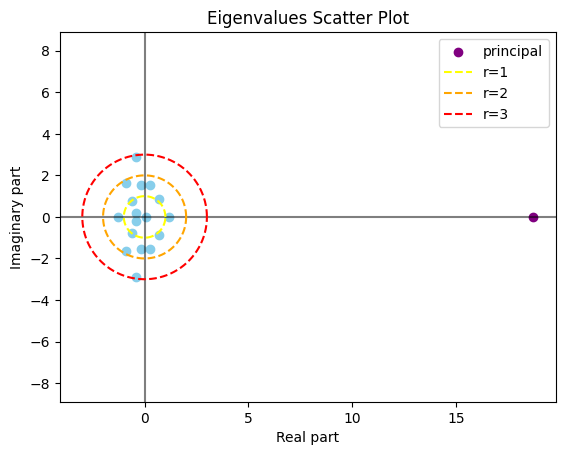

In [96]:
mat.scatter_eigenvalues(df)

# Sorted Perron Eigenvector Damage In

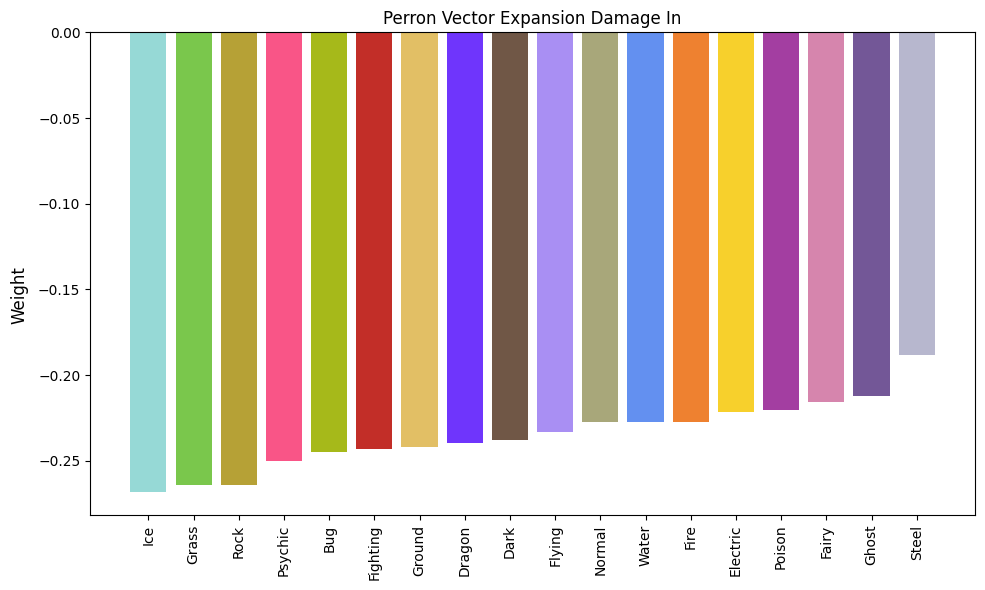

In [97]:
val_in, vec_in = mat.perron_dense(df, side='row')
viz.barcharts(-vec_in, sort='True', color_by='types', title='Damage In')

We can see ghost and steel take in the least damage as expected. Ice and Grass are the worst types receiving the most damage

# Sorted Perron Eigenvector Damage Out

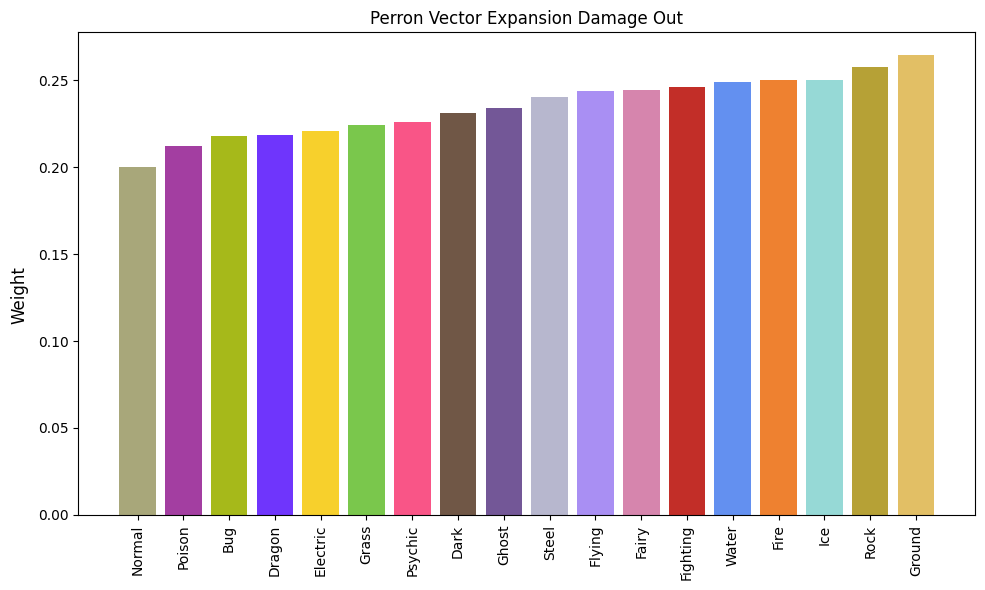

In [98]:
val_out, vec_out = mat.perron_dense(df, side='col')
viz.barcharts(vec_out, sort='True', color_by='types', title='Damage Out')

Just like in the video we see ground and rock are the heavy hitters. While normal is the worst at dealing damage given them having no x2 damage output.

# Difference of eigenvectors Net Damage

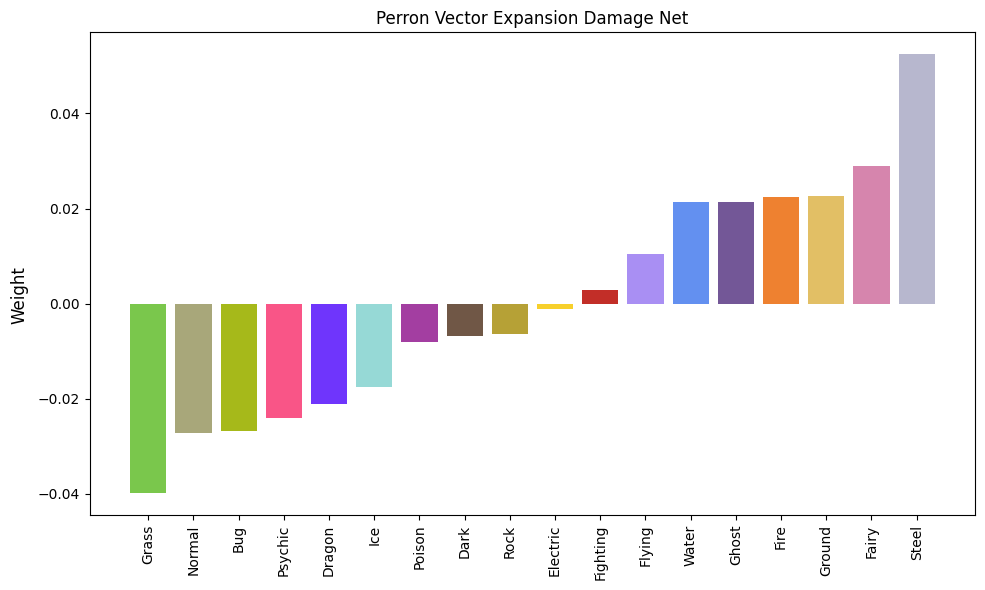

In [99]:
vec_net = vec_out - vec_in
viz.barcharts(vec_net, sort='True', color_by='types', title='Damage Net')

By looking at the differences of damage out vs damage in we see steel's defensive capabilties make up for its mid aggression. Next up in second place is fairy with high defense and mid aggression, analogous to steel, but surpassing ghost. Ground has high enough offesnse to overcome its mid defenses. Fire has a similar story, almost tied with ground. Meanwhile Rock with high attack but abysmal defense has dropped to the bottom of the ranking. This analysis seems to suggest in pokemon battles defense is more important than attack.

# lets turn this into a stochastic matrix by scaling rows

If we scale the matrix, we can also think of the transition rates as probabilities.

In [100]:
dfsr = mat.stochastic_matrix(df, by='row')
# check sum for each row = 1
dfsr.sum(axis=1)

Normal      1.0
Fire        1.0
Water       1.0
Electric    1.0
Grass       1.0
Ice         1.0
Fighting    1.0
Poison      1.0
Ground      1.0
Flying      1.0
Psychic     1.0
Bug         1.0
Rock        1.0
Ghost       1.0
Dragon      1.0
Dark        1.0
Steel       1.0
Fairy       1.0
dtype: float64

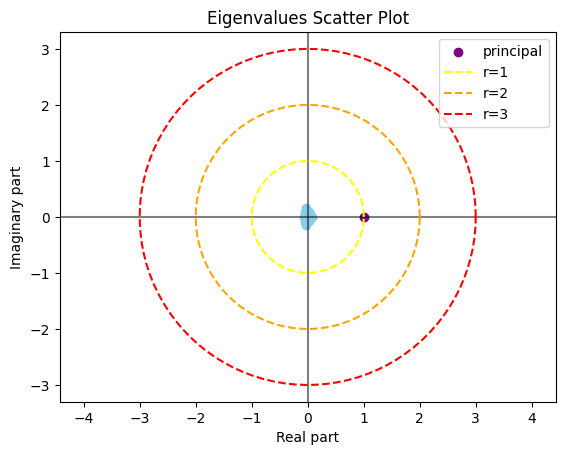

In [101]:
mat.scatter_eigenvalues(dfsr)

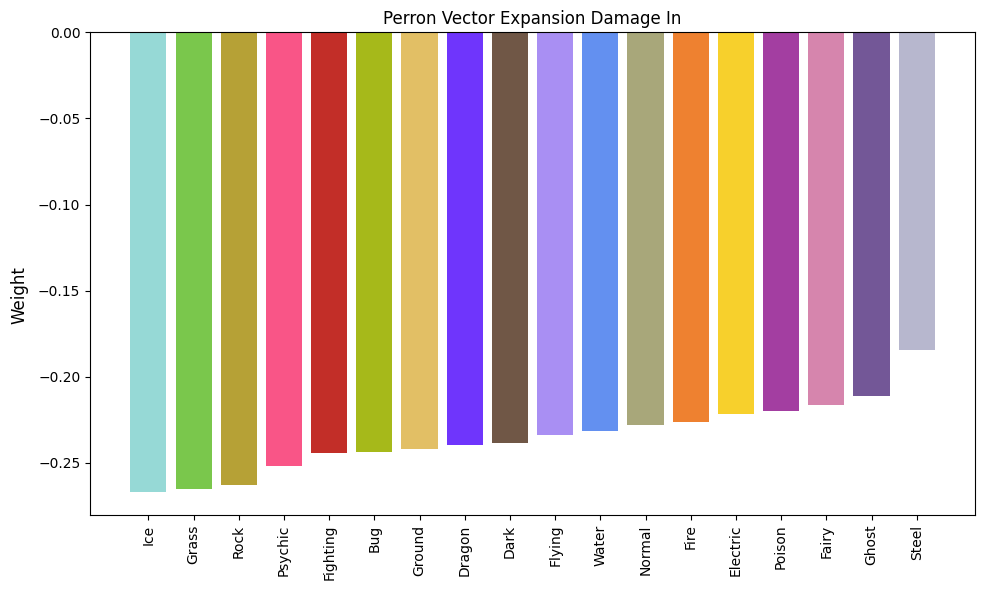

In [102]:
val_in, vec_in = mat.perron_dense(dfsr, side='row')
viz.barcharts(-vec_in, sort='True', color_by='types', title='Damage In')

Top 3 and bottom 3 defenders seem preserved

# lets turn this into a stochastic matrix by scaling COLS

In [103]:
dfsc = mat.stochastic_matrix(df, by='col')
# check sum for each col = 1
dfsc.sum(axis=0)

Normal      1.0
Fire        1.0
Water       1.0
Electric    1.0
Grass       1.0
Ice         1.0
Fighting    1.0
Poison      1.0
Ground      1.0
Flying      1.0
Psychic     1.0
Bug         1.0
Rock        1.0
Ghost       1.0
Dragon      1.0
Dark        1.0
Steel       1.0
Fairy       1.0
dtype: float64

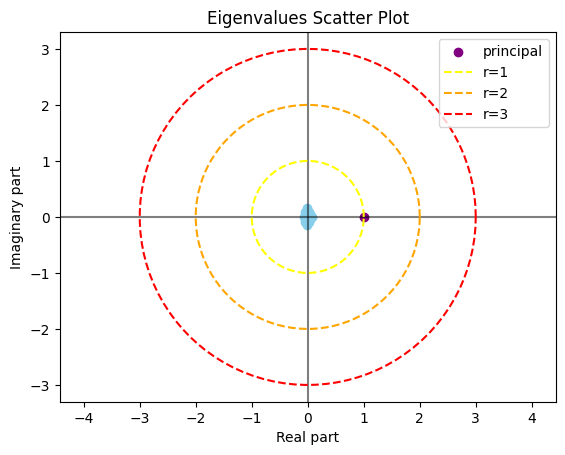

In [104]:
mat.scatter_eigenvalues(dfsc)

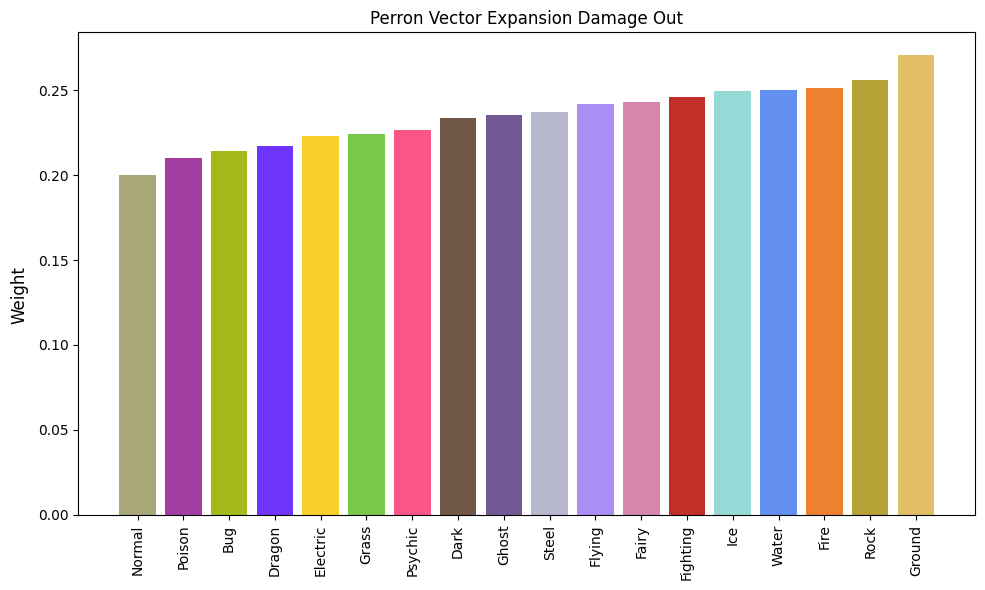

In [105]:
val_out, vec_out = mat.perron_dense(dfsc, side='col')
viz.barcharts(vec_out, sort='True', color_by='types', title='Damage Out')

Top 3 and bottom 3 attackers seem preserved

# net damage difference

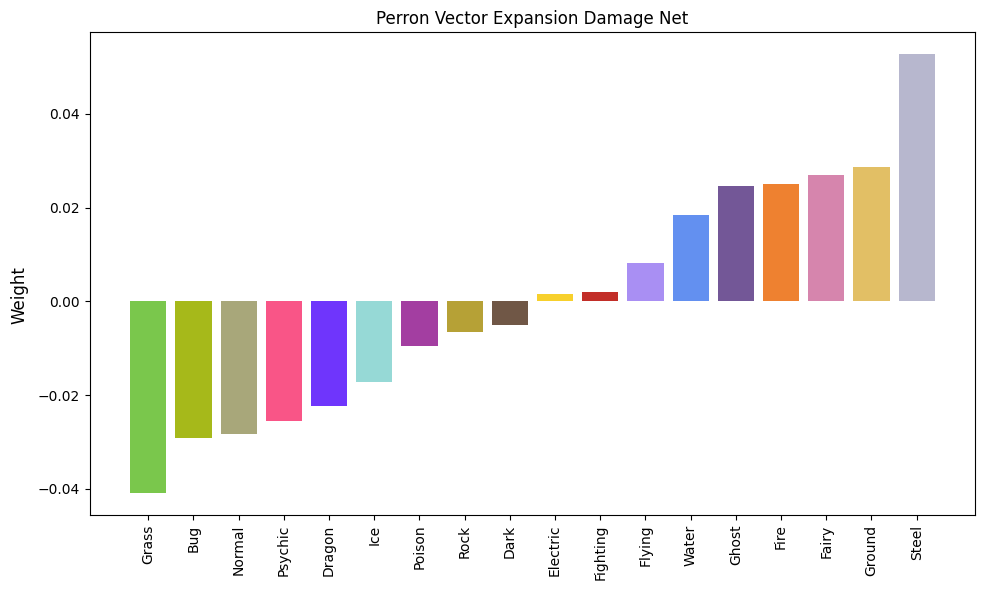

In [107]:
vec_net = vec_out - vec_in
viz.barcharts(vec_net, sort='True', color_by='types', title='Damage Net')

Recaling columns didn't make major adjustments, as steel still dominates by a ton. However, ground surpasses fairy here. Fire is above ghost too, suggesting offense can be a bit more improtant than originally given credit.

# now lets turn the matrix into probabilities by rescaling proportions with the transpose to factor in both attack and defense into a single number

if $m_{ij} + m_{ji}=0: p_{ij} = p_{ji} = 0.5$ 

be careful with the fringe case when both matchs up are 0

else $p_{ij} =\frac{m_{ij}} {(m_{ij} + m_{ji})}$

In [108]:
dfp = mat.pair_probability_matrix(df)
# check sum withtranspose is all 1's
dfp + dfp.T

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Fire,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Water,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Electric,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Grass,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Ice,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Fighting,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Poison,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Ground,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Flying,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


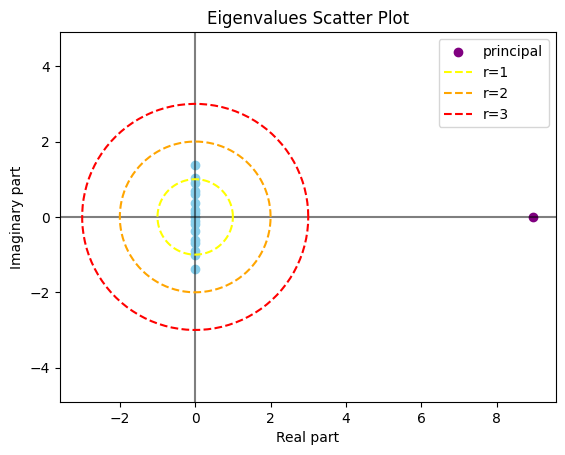

In [109]:
mat.scatter_eigenvalues(dfp)

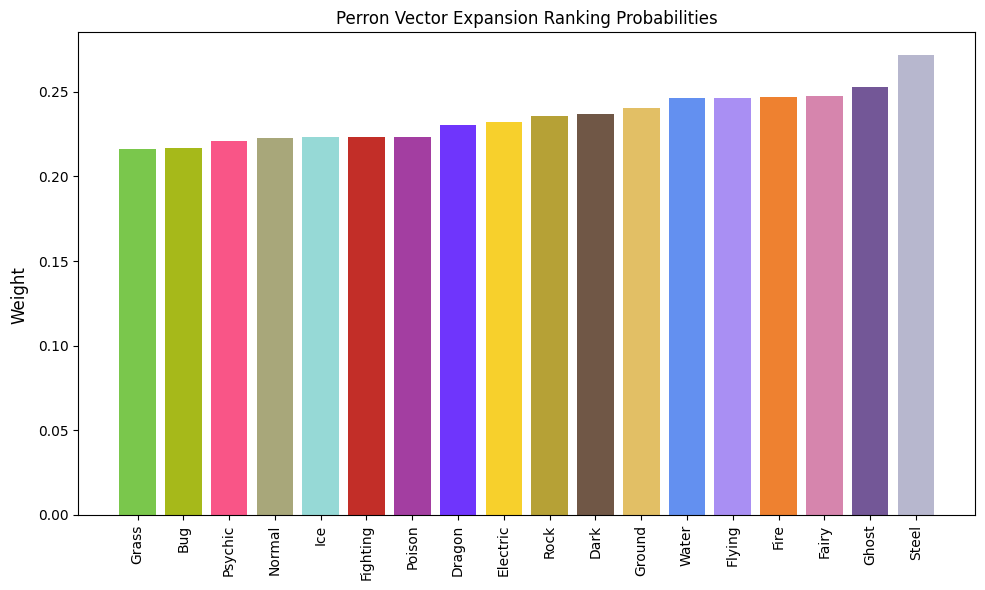

In [110]:
val_out, vec_out = mat.perron_dense(dfp, side='col')
viz.barcharts(vec_out, sort='True', color_by='types', title='Ranking Probabilities')

We see that steel still ranks in the top, but not by much as previous analysis, due to rescaling. Hoewver a big difference we see ghost stay at the top and Ground drop to mid. Fire manages to stay in the top. We see the top 3 pokemon types dominate thanks to their high defensesm again hinting at the importance of this vs attack.